# Social Network Analysis using Alumni Event Attendance Data

In this exercise, we'll be using sample data from an Alumni Events program to put together a *Social Network Analysis* diagram (also sometimes referred to as *relationship mapping*. The purpose of this exercise is as follows:
* **A)** To find instances where alumni have attended more than one event together
* **B)** Identify instances where alums who are *already* major donors can potentially help with engaging their fellow event attendees who have not yet donated.

Let's begin by importing the requisite Python libraries:

In [112]:
import pandas as pd # Dataframes
import matplotlib.pyplot as plt # Create plots, graphs, etc.
import pyodbc # Used for querying in data from an external database environment
import networkx as nx # Used for creating social netowrk diagrams
import mplcursors # Used for adding annotations to matplotlib figures

# Default to centering matplotlib within the notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Ignore warnings
import warnings 
warnings.filterwarnings("ignore")

Next, we'll connect to the database that houses the sample event attendance data we will be using.

In [113]:
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};'
                      'SERVER=localhost;'
                      'DATABASE=Philanthropy;'
                      'UID=ANDREWACER\andre;'
                      'Trusted_Connection=yes;')

Great. Now, let's query in the sample university alumni events dataset we'll be using. Here's a quick overview of the data sources:
* Event details within this dataset (including event names, locations, dates, and more) have been generated using **ollama**, a locally-hosted large language model.
* Constituent data within this dataset (including first and last names, addresses, and more) has been randomly-generated using Python's **"Faker"** library.
* Lifetime giving amounts have been generated through Python's **randint()** function.

In [114]:
sql = """
SELECT 
[ID],
[Last Name],
[First Name],
[Birthdate],
[Age],
[Address Line 1],
[City],
[ST],
[ZIP],
[Alumnus],
[School],
[GradYear],
[Manager],
[Attendee Type],
[Event ID],
[Event Name],
[Event Date],
[Event Type],
[Event State],
[Lifetime Giving]
FROM [Philanthropy].[dbo].[EventsSocialNetworkView]
"""
df = pd.read_sql(sql,conn)

And let's take a quick peek at that data:

In [115]:
df.head()

,ID,Last Name,First Name,Birthdate,Age,Address Line 1,City,ST,ZIP,Alumnus,School,GradYear,Manager,Attendee Type,Event ID,Event Name,Event Date,Event Type,Event State,Lifetime Giving
0,103528103893,Cardenas,Keith,1970-02-22,55,50996 Parker Shoals,Mcmillanfurt,NM,62973,Alumnus,School of Business,1993,Laura Steele,Participants,430815,Arizona University Reunion Gala,2018-06-14,Reception,Arizona,42160
1,105879896660,Brewer,Kristin,1966-07-25,58,28242 Michael Pass Apt. 882,Medinabury,MI,79053,Alumnus,College of Nursing,1989,Robert Novak,Participants,795093,Rutgers Alumni Tailgate Party '18,2018-11-19,Tailgate Party,New Jersey,0
2,110690223496,Morales,Jonathan,1953-11-27,71,7074 Wolf Island Suite 859,East Robertmouth,IA,75893,Alumnus,Medical School,1976,Kelly Walsh,Participants,314135,University Alumni Reception 2018,2018-05-07,Reception,Indiana,80
3,113154179902,Owens,Jason,1966-02-21,59,837 Gonzalez Burg,Kristenberg,PA,09479,Non-Alum,,,,Participants,795093,Rutgers Alumni Tailgate Party '18,2018-11-19,Tailgate Party,New Jersey,43000
4,130768375418,Baker,Amy,1947-02-25,78,75391 Soto Loop Suite 199,Alvarezville,UT,46395,Alumnus,School of Public Policy,1970,Jennifer Weaver,Participants,314135,University Alumni Reception 2018,2018-05-07,Reception,Indiana,4100


*Social networks* are primarily made up of **nodes** (representing the individual constituents within the network), and **edges** (representing the relationships between those constituents). For the purposes of this exercise, the primary *nodes* will be the unique identifiers corresponding to each alumni event that occurred; the secondary *nodes* (connected to the primary nodes via edges) will be the individual constituents who attended those events.

Let's go ahead and create a list of nodes and edges by iterating through the list of Event and Consituent IDs, pulling out all possible combinations. Then, we'll initialize our social network graph via NetworkX:

In [116]:
# Create graph
G = nx.Graph()

# Create nodes and edges
edges = df[['Event ID','ID']].values.tolist()

# Count how many times each pair attended together
edge_df = pd.DataFrame(edges, columns=['Source', 'Target'])
edge_weights = edge_df.value_counts().reset_index(name='weight')

# Add edges with weights
for _, row in edge_weights.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['weight'])

# Populate diagram
pos = nx.spring_layout(G, seed=42)  # Layout for consistent visuals
weights = [G[u][v]['weight'] for u, v in G.edges()]

Next, let's populate a dictionary with the event names and IDs to serve as labels for the diagram:

In [117]:
# Pull out event information
labeldict = {}
for index, row in df[['Event ID','Event Name']].drop_duplicates().iterrows():
    labeldict[row['Event ID']] = row['Event Name']

And for constituents (we'll use this for annotation purposes):

In [118]:
# Pull out attendees
attendees = df[['ID','Last Name','First Name','Age','City','ST','ZIP','Alumnus','School','GradYear','Lifetime Giving']].drop_duplicates().rename(columns={'Last Name': 'LastName', 'First Name': 'FirstName', 'Lifetime Giving': 'LifetimeGiving'})

# Add attendee indices to networkx diagram
for node_id in attendees['ID']:
    x, y = pos[node_id]

And finally for constituents who have attended more than one event - we will use this for coloring the diagram:

In [119]:
# Pull out attendees who have attended more than one event
multi_attends = []
for ID, group in df.groupby('ID'):
    if len(list(group['ID'])) > 1:
        multi_attends.append(ID)

Now let's populate our color map, setting the color that will correspond to each node. "Event" nodes will be colored in <font color='green'>green</font>, nodes for attendees who have attended more than one event will be colored in <font color='red'>red</font>, and the remaining constituent nodes will be colored in <font color='blue'>blue</blue>.

In [120]:
# Create node color map
color_map = []
for node in G:
    if node in multi_attends: # multi-event attendee nodes colored in red   
        color_map.append('red')
    elif node in df['Event ID'].unique(): # Color event nodes in green
        color_map.append('green')
    else: 
        color_map.append('skyblue') # Color all remaining attendee nodes in blue    

We can do the same with a "node size" map. "Event" nodes will be sized larger than the "attendee" nodes to make them stand out more on the diagram.

In [121]:
# Create node size map
size_map = []
for node in G:
    if node in df['Event ID'].unique(): # Set event nodes to be larger then attendee nodes
        size_map.append(400)
    else: 
        size_map.append(100)

Let's add some code to generate hovering annotations that show relevant constituent demographic info, when mousing over any of the attendees' nodes. Credit for this segment goes to this documentation: https://mplcursors.readthedocs.io/en/stable/examples/dataframe.html

In [122]:
# Function to define hover annotations
def show_hover_panel(get_text_func=None):
    cursor = mplcursors.cursor(
        hover=2,  # Transient
        annotation_kwargs=dict(
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="yellow",
                alpha=0.9,
                linewidth=0.5,
            ),
            linespacing=1.5,
            fontsize=8,
            ha="left", va="bottom",
            arrowprops=dict(arrowstyle="->", color='black')
        ),
        highlight=True,
        highlight_kwargs=dict(linewidth=2),
    )

    if get_text_func:
        cursor.connect(
            event="add",
            func=lambda sel: sel.annotation.set_text(get_text_func(sel.index)),
        )
    return cursor

In [125]:
# Function to define annotation contents
def on_add(index):
    alum = attendees.iloc[index]
    parts = [
        f"{alum.FirstName} {alum.LastName}",
        f"{alum.City}, {alum.ST} {alum.ZIP}",
        f"Lifetime Giving: ${alum.LifetimeGiving:,.0f}",
    ]
    if alum.GradYear != "":
        parts.append(f"{alum.School}, Class of {alum.GradYear}")
    return "\n".join(parts)

Now let's add in our event node annotations and view the final graph:

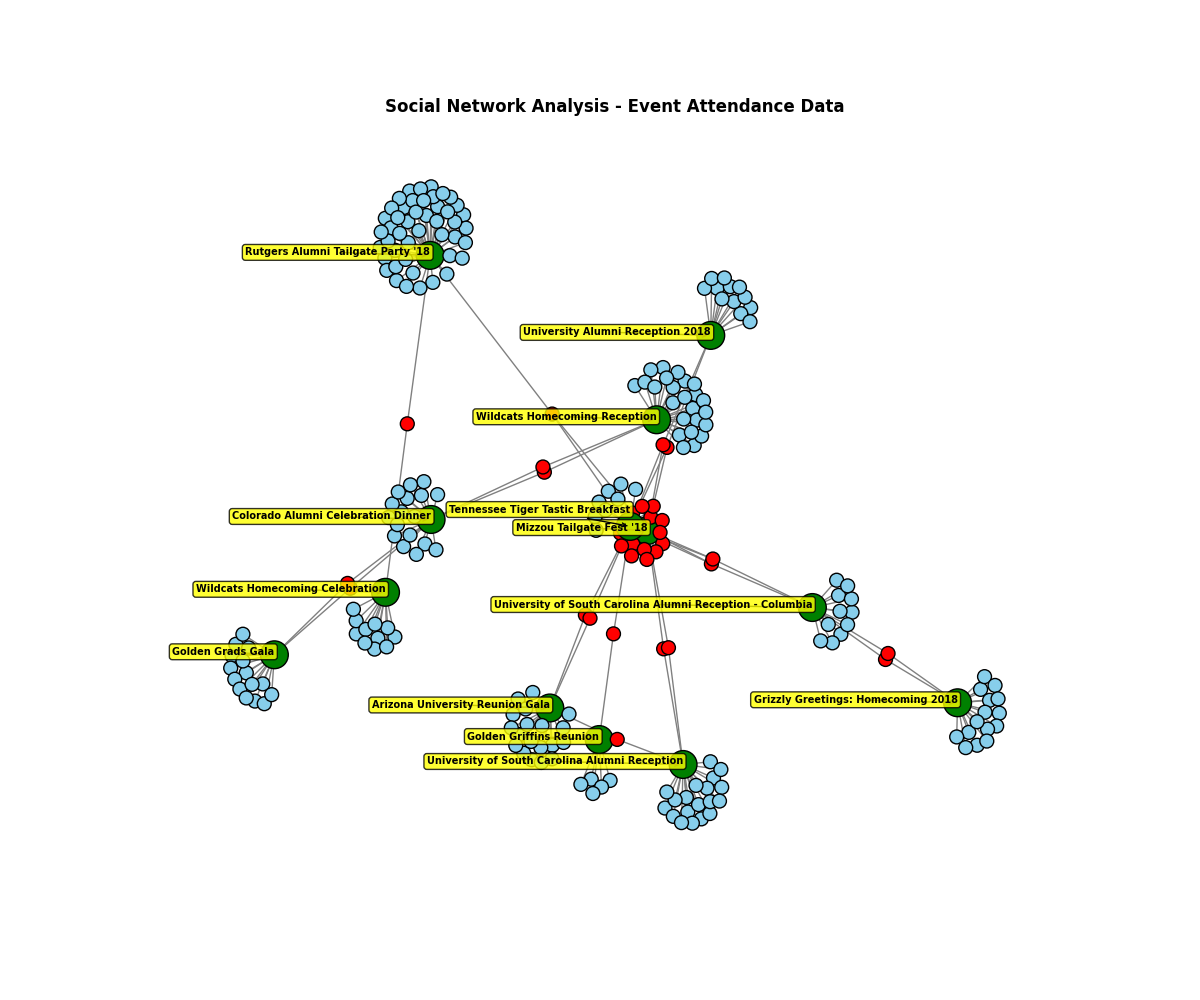

In [126]:
%matplotlib ipympl

plt.figure(figsize=(12, 10), dpi=100)
plt.title("Social Network Analysis - Event Attendance Data", fontsize=12, weight='bold')
nx.draw(G, pos, labels=labeldict, with_labels=False, node_color=color_map, edge_color='gray', edgecolors='black', width=weights, node_size=size_map)

# Annotate event nodes
for node_id, label in labeldict.items():
    x, y = pos[node_id]
    if label == 'Tennessee Tiger Tastic Breakfast': # fix overlapping labels
        xy = 10
    else:
        xy = 0
    plt.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext = (0,xy),
        ha='right', # text alignment
        fontsize=7,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.8), # text box format
        arrowprops=dict(arrowstyle="->", color='black') # arrow format
    )

show_hover_panel(on_add)
plt.show()